## Maciej Olszewski

This is a jupyter notebook wrapper to run detect-classify traffic signs app.

In [1]:
%%capture
!pip install ultralytics

In [2]:
!pip install kaggle

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [5]:
import kaggle
# !kaggle datasets list -s meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
# !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb

Dataset URL: https://www.kaggle.com/datasets/safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
License(s): unknown
 99% 1.60G/1.61G [00:48<00:00, 21.6MB/s]
100% 1.61G/1.61G [00:48<00:00, 35.4MB/s]


In [6]:
!unzip german-traffic-sign-detection-benchmark-gtsdb.zip;

Archive:  german-traffic-sign-detection-benchmark-gtsdb.zip
  inflating: TestIJCNN2013/TestIJCNN2013Download/00000.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00001.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00002.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00003.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00004.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00005.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00006.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00007.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00008.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00009.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00010.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00011.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00012.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00013.ppm  
  inflating: TestIJCNN2013/TestIJCNN2013Download/00014.ppm  
  inflating: TestIJCNN201

In [7]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from datetime import datetime
import os
DIR_RESULTS = f"/content/drive/MyDrive/Colab/application/results/{datetime.today()}"
os.makedirs(DIR_RESULTS, exist_ok=True)

In [10]:
!git clone https://github.com/machofvmaciek/master_thesis_road_signs_detect_recog.git

Cloning into 'master_thesis_road_signs_detect_recog'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Receiving objects: 100% (23/23), 141.66 MiB | 28.85 MiB/s, done.
Updating files: 100% (15/15), done.


In [11]:
import os
import cv2

import matplotlib.pyplot as plt

from master_thesis_road_signs_detect_recog.src.detect import Detector, NoDetectionsException
from master_thesis_road_signs_detect_recog.src.classify import Classifier

In [12]:
# DIR_TEST_IMAGES = "/Users/machofv/Downloads/GTSDB-archive-2/TrainIJCNN2013/TrainIJCNN2013"
DIR_TEST_IMAGES = "TestIJCNN2013/TestIJCNN2013Download"

In [16]:
def enhance_contrast_adaptive(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])  # Apply CLAHE to the Y (luminance) channel
    img_enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_enhanced

def visualize(img, imgs_detected, predictions, j_counter, is_saved=False):
    plt.subplots_adjust(top=0.90)
    fig, axs = plt.subplots(1, 1+len(predictions), figsize=(15, 5))

    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original image')
    axs[0].axis('off')

    for i, img_disp in enumerate(imgs_detected):
        axs[i+1].imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(predictions[i])
        axs[i+1].axis("off")
    plt.tight_layout()
    if is_saved:
        plt.savefig(f"{DIR_RESULTS}/result_{j_counter}")
    else:
        plt.show()

def visualize_enhanced(img, imgs_detected, imgs_enhanced, predictions, j_counter, is_saved=False):
    plt.subplots_adjust(top=0.90)
    fig, axs = plt.subplots(2, 1+len(predictions), figsize=(15, 5))

    axs[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0][0].set_title('Original image')
    axs[0][0].axis('off')
    axs[1][0].axis("off")

    for i, img_disp in enumerate(imgs_detected):
        axs[0][i+1].imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
        axs[0][i+1].set_title(predictions[i])
        axs[0][i+1].axis("off")

        axs[1][i+1].imshow(cv2.cvtColor(imgs_enhanced[i], cv2.COLOR_BGR2RGB))
        axs[1][i+1].set_title("(inc. contrast)")
        axs[1][i+1].axis("off")

    plt.tight_layout()
    if is_saved:
        plt.savefig(f"{DIR_RESULTS}/result_{j_counter}")
    else:
        plt.show()
    
def run_from_folder(DIR_IMAGES, detector, classifier, is_enhanced=True, is_saved=False):
    test_imgs = os.listdir(DIR_IMAGES)
    for j, IMG_PATH in enumerate(test_imgs[227:230]):

        imgs_detected = []
        if IMG_PATH == ".DS_Store":
            continue
        try:
            imgs_detected = detector.detect_yolo(f"{DIR_IMAGES}/{IMG_PATH}")
        except NoDetectionsException:
            continue

        predictions = []
        if is_enhanced: imgs_enhanced = []

        if imgs_detected:
            for img_detected in imgs_detected:

                if is_enhanced:
                    # img_enhanced = cv2.convertScaleAbs(img_detected, alpha=1.5, beta=15)
                    img_enhanced = enhance_contrast_adaptive(img_detected)
                    imgs_enhanced.append(img_enhanced)
                    predictions.append(classifier.predict(img_enhanced))
                else:
                    predictions.append(classifier.predict(img_detected))

            NUM_OF_PREDS = len(predictions)
            img = cv2.imread(f"{DIR_IMAGES}/{IMG_PATH}")

            # Visualize the data
            if is_enhanced:
                visualize_enhanced(img, imgs_detected, imgs_enhanced, predictions, j, is_saved=is_saved)
            else:
                visualize(img, imgs_detected, predictions, j, is_saved=is_saved)

In [14]:
detector = Detector()
classifier = Classifier()


0: 384x640 2 Traffic signs, 126.2ms
Speed: 4.8ms preprocess, 126.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 123ms/step

0: 384x640 2 Traffic signs, 84.6ms
Speed: 4.2ms preprocess, 84.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 76ms/step

0: 384x640 2 Traffic signs, 94.7ms
Speed: 3.8ms preprocess, 94.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
1/1 [==============================] - 0s 78ms/step


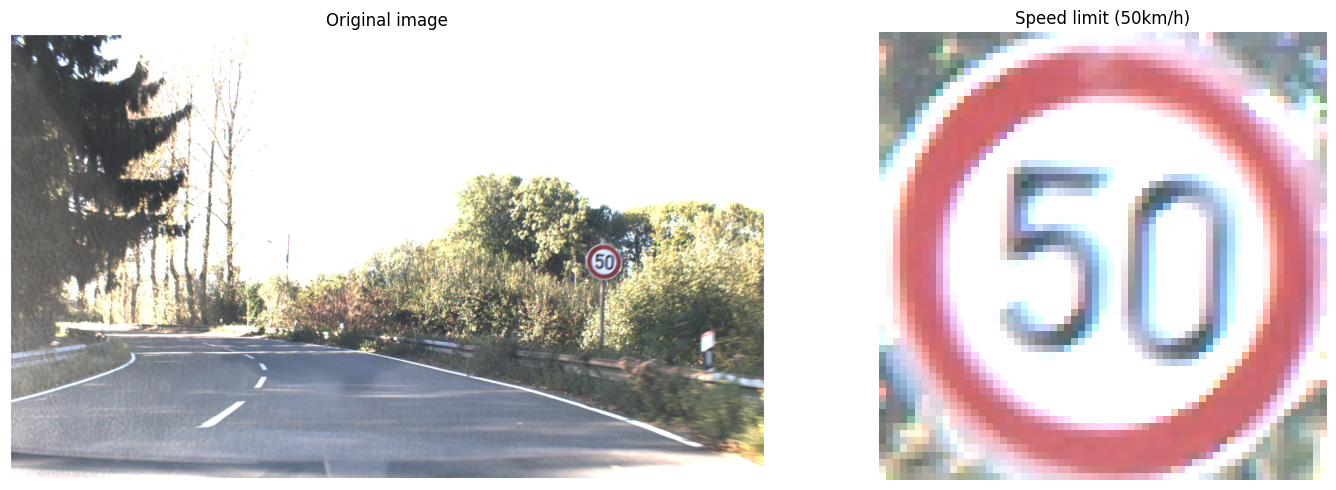

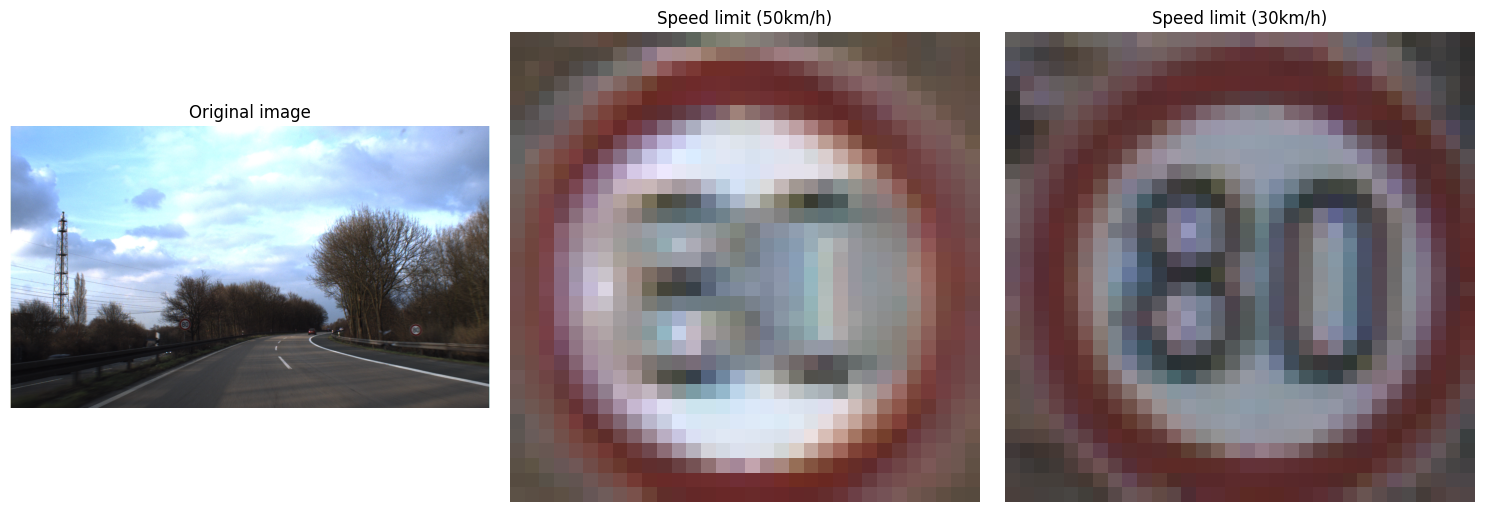

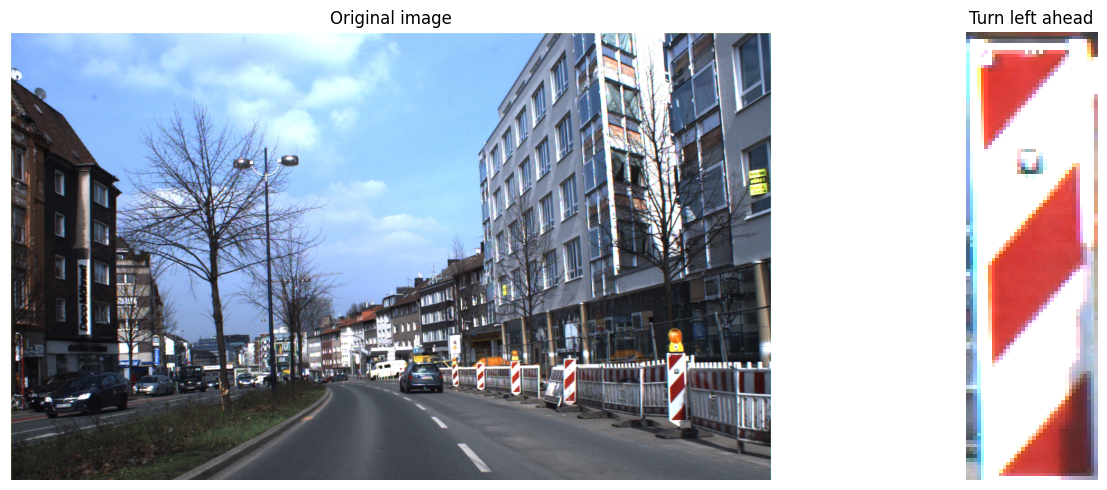

In [17]:
run_from_folder(DIR_TEST_IMAGES, detector, classifier, is_enhanced=True, is_saved=True)